## Probalistic Confirmed COVID19 Cases- Denmark

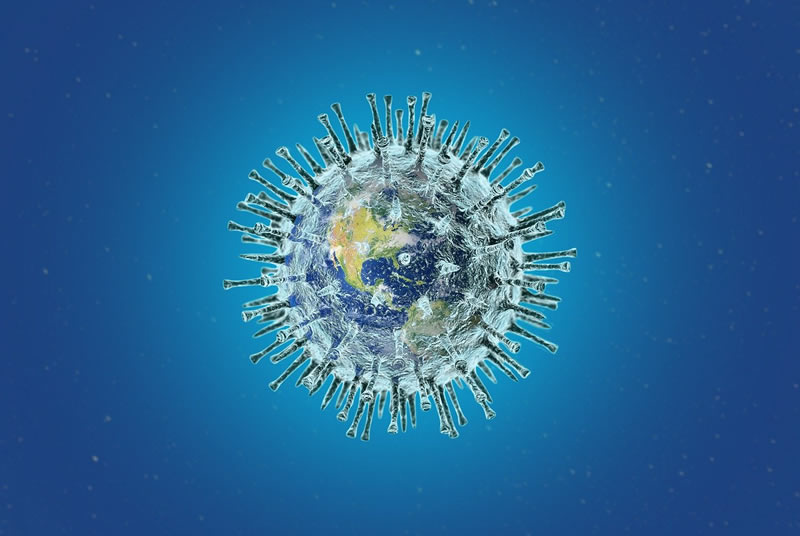

In [6]:
from os.path import join, pardir
ROOT = pardir
file = join(ROOT, "data", "raw", "covid19.jpg")
from IPython.display import Image
Image(filename=file)

## Required Packages

In [7]:

# plotly than matplo.....
import plotly.express as px
import plotly.graph_objects as go

# Pandas is needed in most of the cases:
import pandas as pd

# The code below will make the GUI to upload the local file
# want to run the initial analysis
import time
import numpy as np

 #!pip install numpyro

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax
from sklearn.preprocessing import StandardScaler
np.random.seed(42)

## Initialization

In [8]:
# random seed
np.random.seed(42)

#plot style
plt.style.use('ggplot')

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## Data Importing and Processing

The data in this case are the confirmed cases of the COVID-19 and the the mobility data for three specific
country: Denmark, Sweden and Norway.


In [9]:
ROOT = pardir
adress = join(ROOT, "data", "processed")
data = pd.read_csv(join(adress, 'data_three_mob_cov.csv'),parse_dates=['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        268 non-null    datetime64[ns]
 1   Country     268 non-null    object        
 2   Confirmed   268 non-null    int64         
 3   ret_rec_ch  268 non-null    int64         
 4   gr_ph_ch    265 non-null    float64       
 5   par_cha     268 non-null    int64         
 6   tra_sta_ch  268 non-null    int64         
 7   wor_ch      268 non-null    int64         
 8   res_ch      268 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 19.0+ KB


In [27]:
data.head(5)

,Date,Country,Confirmed,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
0,2020-02-27,Denmark,1,2,1.0,21,2,3,0
1,2020-02-28,Denmark,1,17,1.0,23,6,2,-1
2,2020-02-29,Denmark,3,10,-4.0,-17,5,0,0
3,2020-03-01,Denmark,4,21,-7.0,-5,5,1,0
4,2020-03-02,Denmark,4,11,-5.0,28,1,2,0


## Kalman Filter Modeling: Case of Denmark Data

In [10]:
data_dk=data[data['Country'] == "Denmark"]
data_dk.head(5)

,Date,Country,Confirmed,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
0,2020-02-27,Denmark,1,2,1.0,21,2,3,0
1,2020-02-28,Denmark,1,17,1.0,23,6,2,-1
2,2020-02-29,Denmark,3,10,-4.0,-17,5,0,0
3,2020-03-01,Denmark,4,21,-7.0,-5,5,1,0
4,2020-03-02,Denmark,4,11,-5.0,28,1,2,0


In [36]:
print("The length of the full dataset for Denmark is:" + " " )
print(len(data_dk))

The length of the full dataset for Denmark is: 
85


### Kalman Filter Model vector c fixed as [0, 1], Denamrk 

In [49]:

X = data_dk.iloc[:, 3:].astype(np.float_)
y = data_dk.iloc[:,2].astype(np.float_)

n_train = 65
n_test = len(y)-n_train

idx_train = [*range(0,n_train)]
idx_test = [*range(n_train, len(y))]

y_train = y[idx_train]
y_test = y[idx_test]
"""
X_train = X[idx_train,:]
X_test = X[idx_test,:]
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = np.vstack((X_train, X_test))
"""

'\nX_train = X[idx_train,:]\nX_test = X[idx_test,:]\nscaler = StandardScaler()\nscaler.fit(X_train)\nX_train = scaler.transform(X_train)\nX_test = scaler.transform(X_test)\nX = np.vstack((X_train, X_test))\n'

In [50]:
def f(carry, input_t):
  x_t, noise_t = input_t
  W, beta, z_prev, tau = carry
  z_t = beta*z_prev + W @ x_t + noise_t
  z_prev = z_t
  return (W, beta, z_prev, tau), z_t

In [51]:
def model_wo_c(T, T_forecast, x, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    W = numpyro.sample(name="W", fn=dist.Normal(loc=jnp.zeros((2,4)), scale=jnp.ones((2,4))))
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower), sample_shape=(T+T_forecast,))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (W, beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, (x, noises), T+T_forecast)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
  
    obs_mean = z_collection[:T, 1]
    pred_mean = z_collection[T:,1]

    # Sample the observed y (y_obs) 
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [55]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model_wo_c)
mcmc = MCMC(nuts_kernel, num_samples=9000, num_warmup=3000, num_chains=1)
mcmc.run(rng_key_, T=n_train, T_forecast=n_test, x=X.iloc[:,:4].values, obs=y_train.values)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

KeyboardInterrupt: 

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

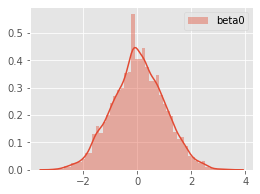

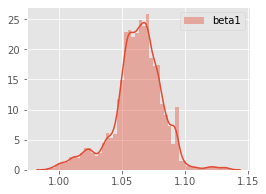

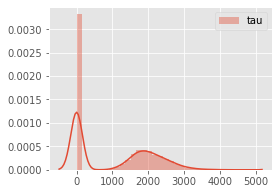

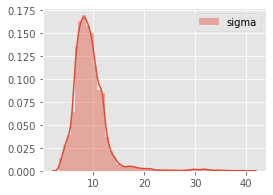

In [0]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

In [0]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)

In [0]:
y_pred_025 = y_hat - 1.96*y_std
y_pred_975 = y_hat + 1.96*y_std

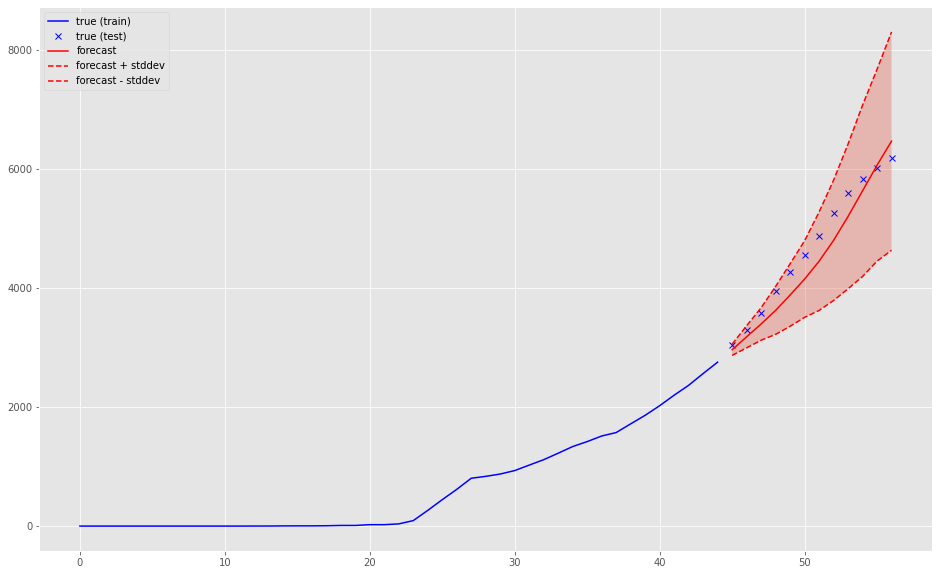

In [0]:
plt.plot(idx_train, y_train, "b-")
plt.plot(idx_test, y_test, "bx")
plt.plot(idx_test, y_hat[:-1], "r-")
plt.plot(idx_test, y_pred_025[:-1], "r--")
plt.plot(idx_test, y_pred_975[:-1], "r--")
plt.fill_between(idx_test, y_pred_025[:-1], y_pred_975[:-1], alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

In [0]:
hmc_samples['W'].mean(axis=0)

DeviceArray([[ 0.10300408, -0.07386437, -0.01444431,  0.0383034 ],
             [ 1.2619253 ,  1.0954776 ,  0.20753448, -1.3710234 ]],            dtype=float32)

### Kalman Filter with the vector c as a random variable with prior, Denamrk 

In [0]:
def model_w_c(T, T_forecast, x, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    W = numpyro.sample(name="W", fn=dist.Normal(loc=jnp.zeros((2,4)), scale=jnp.ones((2,4))))
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.array([0.,0.]), scale=jnp.ones(2)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower), sample_shape=(T+T_forecast,))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (W, beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, (x, noises), T+T_forecast)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    c = numpyro.sample(name="c", fn=dist.Normal(loc=jnp.array([[0.], [0.]]), scale=jnp.ones((2,1))))
    obs_mean = jnp.dot(z_collection[:T,:], c).squeeze()
    pred_mean = jnp.dot(z_collection[T:,:], c).squeeze()

    # Sample the observed y (y_obs) 
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [0]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model_w_c)
mcmc = MCMC(nuts_kernel, num_samples=9000, num_warmup=3000, num_chains=1)
mcmc.run(rng_key_, T=n_train, T_forecast=n_test, x=X, obs=y_train)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 12000/12000 [04:50<00:00, 41.29it/s, 1023 steps of size 4.06e-04. acc. prob=0.88]


Total time: 4.949m


In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

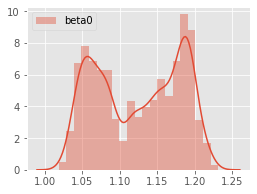

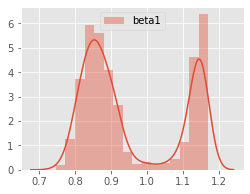

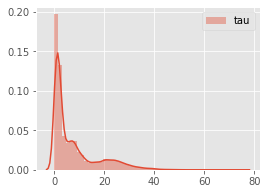

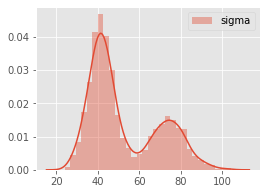

In [0]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

In [0]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)

In [0]:
y_pred_025 = y_hat - 1.96*y_std
y_pred_975 = y_hat + 1.96*y_std

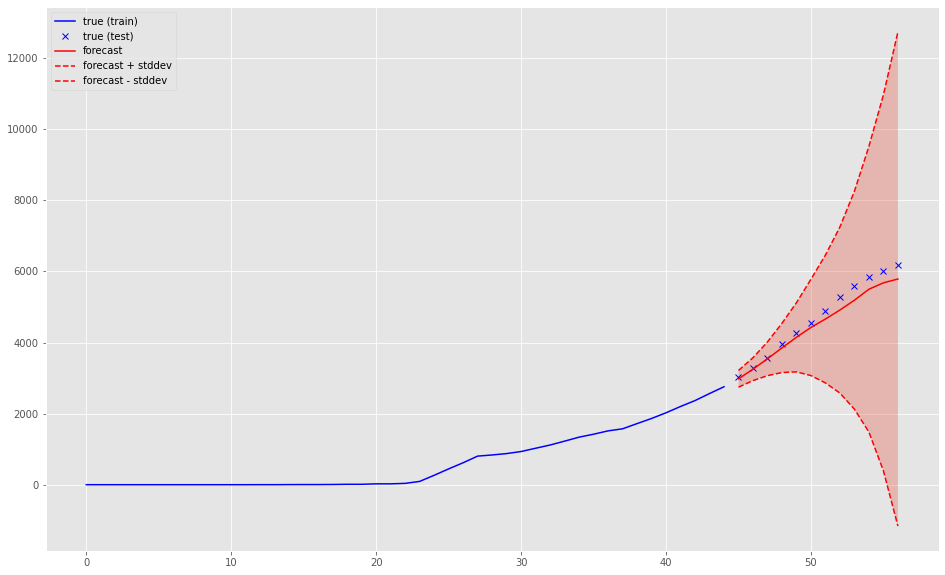

In [0]:
plt.plot(idx_train, y_train, "b-")
plt.plot(idx_test, y_test, "bx")
plt.plot(idx_test, y_hat[:-1], "r-")
plt.plot(idx_test, y_pred_025[:-1], "r--")
plt.plot(idx_test, y_pred_975[:-1], "r--")
plt.fill_between(idx_test, y_pred_025[:-1], y_pred_975[:-1], alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

In [0]:
hmc_samples['W'].mean(axis=0)

DeviceArray([[-0.92419225,  0.5803248 ,  0.14735928, -0.38233298],
             [-0.16688704,  1.5949113 , -0.4462448 , -0.9304285 ]],            dtype=float32)

In [0]:
hmc_samples['c'].mean(axis=0)

DeviceArray([[-1.4487053],
             [ 1.9745528]], dtype=float32)

### Kalman Filter without Input, Denamrk 

In [0]:
def f(carry, input_t):
  noise_t = input_t
  beta, z_prev, tau = carry
  z_t = beta*z_prev + noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

In [0]:
def model_w_c(T, T_forecast, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    #W = numpyro.sample(name="W", fn=dist.Normal(loc=jnp.zeros((2,4)), scale=jnp.ones((2,4))))
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.array([0.,0.]), scale=jnp.ones(2)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower), sample_shape=(T+T_forecast,))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    c = numpyro.sample(name="c", fn=dist.Normal(loc=jnp.array([[0.], [0.]]), scale=jnp.ones((2,1))))
    obs_mean = jnp.dot(z_collection[:T,:], c).squeeze()
    pred_mean = jnp.dot(z_collection[T:,:], c).squeeze()

    # Sample the observed y (y_obs) 
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=obs_mean, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=pred_mean, scale=sigma), obs=None)

In [0]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model_w_c)
mcmc = MCMC(nuts_kernel, num_samples=9000, num_warmup=3000, num_chains=1)
mcmc.run(rng_key_, T=n_train, T_forecast=n_test, obs=y_train)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 12000/12000 [01:48<00:00, 111.05it/s, 941 steps of size 3.86e-03. acc. prob=0.21]


Total time: 1.909m


In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

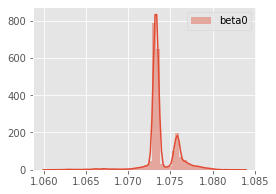

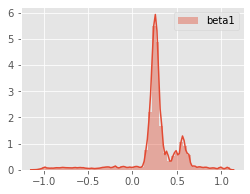

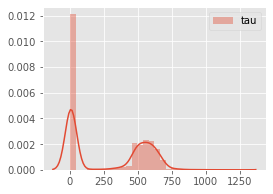

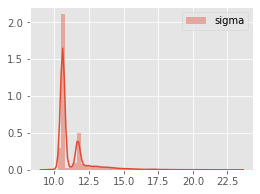

In [0]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

In [0]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)

In [0]:
y_pred_025 = y_hat - 1.96*y_std
y_pred_975 = y_hat + 1.96*y_std

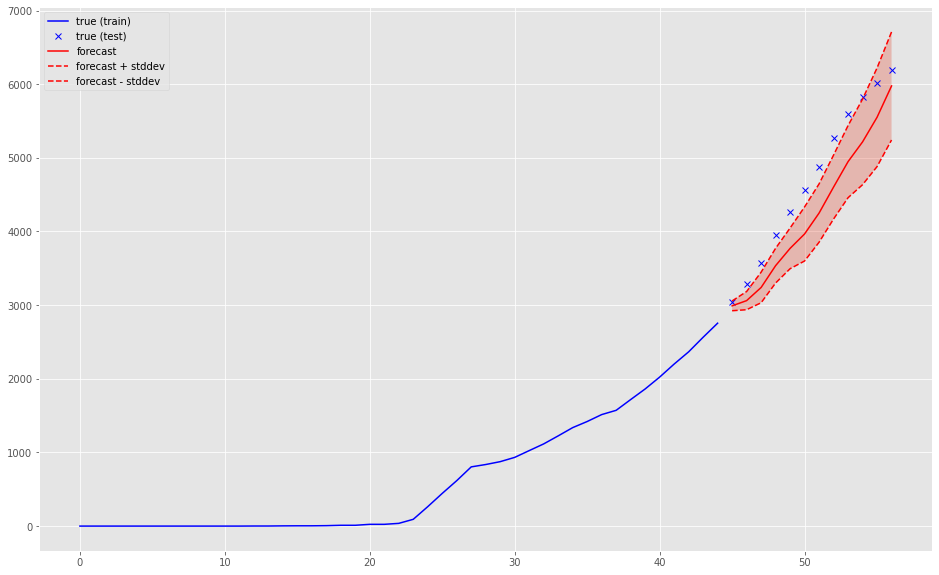

In [0]:
plt.plot(idx_train, y_train, "b-")
plt.plot(idx_test, y_test, "bx")
plt.plot(idx_test, y_hat[:-1], "r-")
plt.plot(idx_test, y_pred_025[:-1], "r--")
plt.plot(idx_test, y_pred_975[:-1], "r--")
plt.fill_between(idx_test, y_pred_025[:-1], y_pred_975[:-1], alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

## Kalman Filter Modeling: Case of Norway Data

In [173]:
data_no=data[data['Country'] == "Norway"]
data_no.reset_index(inplace=True)
data_no.head(5)

,index,Date,Country,Confirmed,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
0,85,2020-02-26,Norway,1,2,2.0,23,1,-4,0
1,86,2020-02-27,Norway,1,1,3.0,14,0,-5,1
2,87,2020-02-28,Norway,6,1,3.0,20,1,-5,1
3,88,2020-02-29,Norway,15,-4,-1.0,2,2,-2,0
4,89,2020-03-01,Norway,19,-10,2.0,-30,-1,-1,0


In [38]:
print("The length of the full dataset for Denmark is:" + " " )
print(len(data_no))

The length of the full dataset for Denmark is: 
86


## Kalman Filter Modeling: Case of Sweden Data

In [39]:
data_sw=data[data['Country'] == "Sweden"]
data_sw.head(5)

,Date,Country,Confirmed,ret_rec_ch,gr_ph_ch,par_cha,tra_sta_ch,wor_ch,res_ch
171,2020-02-15,Sweden,1,2,0.0,3,4,-2,0
172,2020-02-16,Sweden,1,-10,-7.0,-30,-11,-5,2
173,2020-02-17,Sweden,1,-4,-3.0,-3,-6,-6,2
174,2020-02-18,Sweden,1,0,0.0,13,-4,-5,1
175,2020-02-19,Sweden,1,3,1.0,26,-3,-5,1


In [40]:
print("The length of the full dataset for Denmark is:" + " " )
print(len(data_sw))

The length of the full dataset for Denmark is: 
97


## Gaussian Process

In [83]:
import torch
from torch.distributions import constraints
from torch.nn import Parameter

import pyro 
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.nn.module import PyroParam, pyro_method


class VariationalGP(GPModel):
    r"""
    Variational Gaussian Process model.
    This model deals with both Gaussian and non-Gaussian likelihoods. Given inputs\
    :math:`X` and their noisy observations :math:`y`, the model takes the form
    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim p(y) = p(y \mid f) p(f),
    where :math:`p(y \mid f)` is the likelihood.
    We will use a variational approach in this model by approximating :math:`q(f)` to
    the posterior :math:`p(f\mid y)`. Precisely, :math:`q(f)` will be a multivariate
    normal distribution with two parameters ``f_loc`` and ``f_scale_tril``, which will
    be learned during a variational inference process.
    .. note:: This model can be seen as a special version of
        :class:`.SparseVariationalGP` model with :math:`X_u = X`.
    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs. Size of variational parameters is :math:`\mathcal{O}(N^2)`.
    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(f)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.
    :param bool whiten: A flag to tell if variational parameters ``f_loc`` and
        ``f_scale_tril`` are transformed by the inverse of ``Lff``, where ``Lff`` is
        the lower triangular decomposition of :math:`kernel(X, X)`. Enable this flag
        will help optimization.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """
    def __init__(self, X, y, kernel, likelihood, mean_function=None,
                 latent_shape=None, whiten=False, jitter=1e-6):
        super().__init__(X, y, kernel, mean_function, jitter)

        self.likelihood = likelihood

        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        N = self.X.size(0)
        f_loc = self.X.new_zeros(self.latent_shape + (N,))
        self.f_loc = Parameter(f_loc)

        identity = eye_like(self.X, N)
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.whiten = whiten
        self._sample_latent = True

    @pyro_method
    def model(self):
        self.set_mode("model")

        N = self.X.size(0)
        Kff = self.kernel(self.X).contiguous()
        Kff.view(-1)[::N + 1] += self.jitter  # add jitter to the diagonal
        Lff = Kff.cholesky()

        zero_loc = self.X.new_zeros(self.f_loc.shape)
        if self.whiten:
            identity = eye_like(self.X, N)
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=identity)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = Lff.matmul(self.f_scale_tril)
            f_loc = Lff.matmul(self.f_loc.unsqueeze(-1)).squeeze(-1)
        else:
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=Lff)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = self.f_scale_tril
            f_loc = self.f_loc

        f_loc = f_loc + self.mean_function(self.X)
        f_var = f_scale_tril.pow(2).sum(dim=-1)
        if self.y is None:
            return f_loc, f_var
        else:
            return self.likelihood(f_loc, f_var, self.y)

    @pyro_method
    def guide(self):
        self.set_mode("guide")
        self._load_pyro_samples()

        pyro.sample(self._pyro_get_fullname("f"),
                    dist.MultivariateNormal(self.f_loc, scale_tril=self.f_scale_tril)
                        .to_event(self.f_loc.dim()-1))

    def forward(self, Xnew, full_cov=False):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:
        .. math:: p(f^* \mid X_{new}, X, y, k, f_{loc}, f_{scale\_tril})
            = \mathcal{N}(loc, cov).
        .. note:: Variational parameters ``f_loc``, ``f_scale_tril``, together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).
        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        self._check_Xnew_shape(Xnew)
        self.set_mode("guide")

        loc, cov = conditional(Xnew, self.X, self.kernel, self.f_loc, self.f_scale_tril,
                               full_cov=full_cov, whiten=self.whiten, jitter=self.jitter)
        return loc + self.mean_function(Xnew), cov

In [155]:
def plot(plot_observed_data=True, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X_train_tensor.view(-1,).numpy(), y_train_tensor.view(-1,).numpy(), 'kx')
    #if plot_test_points:
    #    plt.plot(x_test.T, y_test.T,'b')
    if plot_predictions:
        Xtest = torch.linspace(0, 85, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest.double(), full_cov=True)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
        plt.legend(["Data","GP Posterior Mean"])
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(70, 85, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(0, 85)

In [85]:
x_train=data_dk.loc[:70,'Date'].index.values.reshape(-1,1).astype('float')
y_train=data_dk.loc[:70,'Confirmed'].values.reshape(-1,1).astype('float')

In [107]:
x_test=data_dk.loc[71:85,'Date'].index.values.reshape(-1,1).astype('float')
y_test=data_dk.loc[71:85,'Confirmed'].values.reshape(-1,1).astype('float')

In [86]:
X_train_tensor = torch.from_numpy(x_train).view(-1,)
y_train_tensor = torch.from_numpy(y_train).view(-1,)

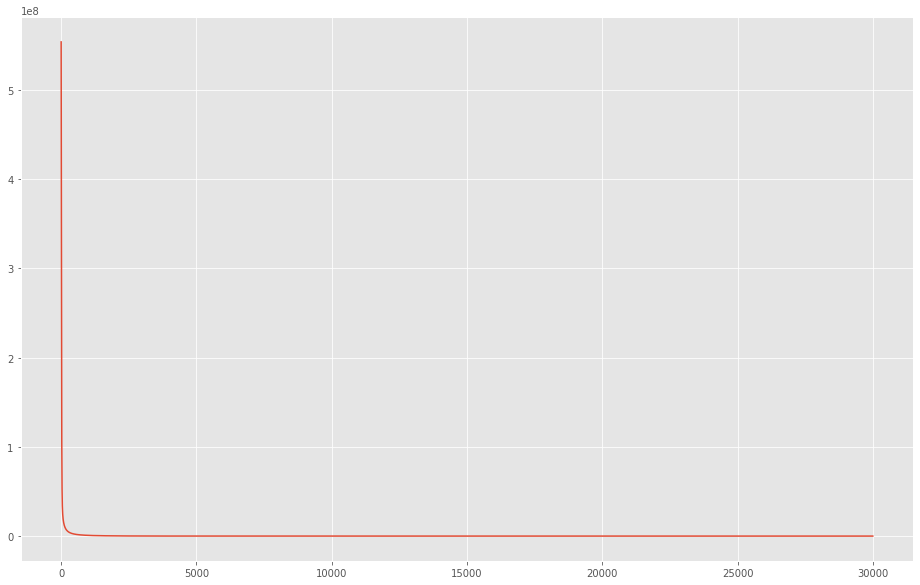

In [99]:
# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# turn on "whiten" flag for more stable optimization
vsgp = VariationalGP(X_train_tensor.view(-1,), y_train_tensor.view(-1,), kernel, likelihood=likelihood, whiten=True)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 30000
losses = gp.util.train(vsgp, num_steps=num_steps)
plt.plot(losses);

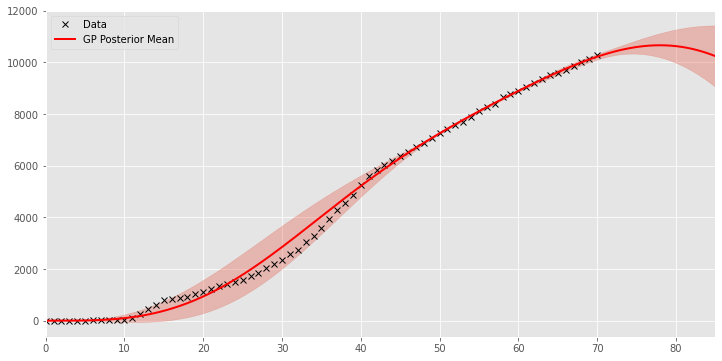

In [156]:
plot(model=vsgp, plot_observed_data=True,plot_predictions=True)

In [175]:
x_train=data_no.loc[:70,'Date'].index.values.reshape(-1,1).astype('float')
y_train=data_no.loc[:70,'Confirmed'].values.reshape(-1,1).astype('float')

x_test=data_no.loc[71:85,'Date'].index.values.reshape(-1,1).astype('float')
y_test=data_no.loc[71:85,'Confirmed'].values.reshape(-1,1).astype('float')

X_train_tensor = torch.from_numpy(x_train).view(-1,)
y_train_tensor = torch.from_numpy(y_train).view(-1,)


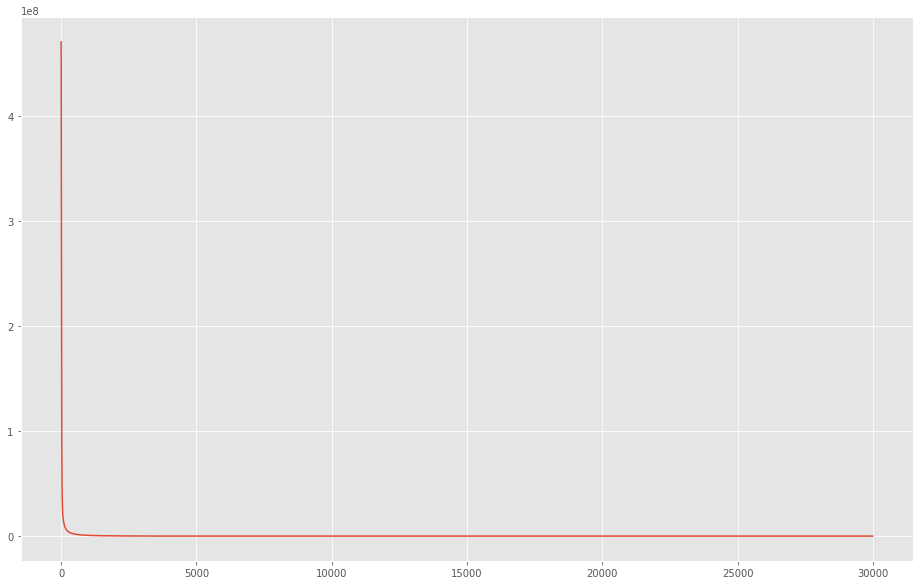

In [177]:
# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# turn on "whiten" flag for more stable optimization
vsgp = VariationalGP(X_train_tensor.view(-1,), y_train_tensor.view(-1,), kernel, likelihood=likelihood, whiten=True)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 30000
losses = gp.util.train(vsgp, num_steps=num_steps)
plt.plot(losses);

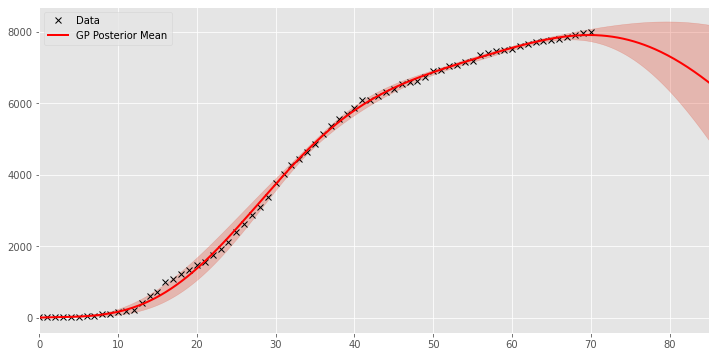

In [178]:
plot(model=vsgp, plot_observed_data=True,plot_predictions=True)